In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dataset

In [3]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip


File ‘ml-20m.zip’ already there; not retrieving.



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [5]:
!ls

ml-20m	ml-20m.zip  sample_data


In [6]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
#lets make new id

# current_user_id = 0 #counter 
# custom_user_map = {} # old user id ----maps--> new user id
# def map_user_id(row):
#     global current_user_id, custom_user_map
#     old_user_id = row['userId']
#     if old_user_id not in custom_user_map:
#        custom_user_map[old_user_id] = current_user_id
#        current_user_id +=1
#     return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1) # to apply this function to every row
# df.head()

#above process is very slow

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes
df.head()

,userId,movieId,rating,timestamp,new_user_id
0,1,2,3.5,1112486027,0
1,1,29,3.5,1112484676,0
2,1,32,3.5,1112484819,0
3,1,47,3.5,1112484727,0
4,1,50,3.5,1112484580,0


In [8]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [9]:
# Get user IDs, movie Ids, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [10]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))
K = 10 # embedding dimension

# Model

In [11]:
#input
u = Input(shape=(1,))
m = Input(shape=(1,))

#embedding
u_emb = Embedding(N,K)(u)
m_emb = Embedding(M,K)(m) #output is (num_samples, 1 , K)

# Flatten
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb) # now its (num_samples, K)

# concatinate embeddings to feature vector
x = Concatenate()([u_emb, m_emb]) # now its(num_samples, 2K)

#we have feature vector, lets make ANN
x = Dense(1024, activation= 'relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u,m], outputs=x)



In [12]:
model.compile(loss='mse', optimizer= SGD(learning_rate=0.08, momentum=0.9))

In [13]:
#split data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

#center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating


In [19]:
r = model.fit(
              x=[train_user,train_movie],
              y =train_ratings,
              epochs=25,
              batch_size=1024,
              #
              verbose=2, #dont print progress bar
              validation_data=([test_user,test_movie],test_ratings))

Epoch 1/25
15626/15626 [==============================] - 335s 21ms/step - loss: 0.6992 - val_loss: 0.6936
Epoch 2/25
15626/15626 [==============================] - 340s 22ms/step - loss: 0.6763 - val_loss: 0.6809
Epoch 3/25
15626/15626 [==============================] - 326s 21ms/step - loss: 0.6621 - val_loss: 0.6762
Epoch 4/25
15626/15626 [==============================] - 323s 21ms/step - loss: 0.6520 - val_loss: 0.6698
Epoch 5/25
15626/15626 [==============================] - 330s 21ms/step - loss: 0.6395 - val_loss: 0.6592
Epoch 6/25
15626/15626 [==============================] - 335s 21ms/step - loss: 0.6239 - val_loss: 0.6476
Epoch 7/25
15626/15626 [==============================] - 350s 22ms/step - loss: 0.6093 - val_loss: 0.6442
Epoch 8/25
15626/15626 [==============================] - 326s 21ms/step - loss: 0.5989 - val_loss: 0.6409
Epoch 9/25
15626/15626 [==============================] - 336s 21ms/step - loss: 0.5902 - val_loss: 0.6368
Epoch 10/25
15626/15626 [============

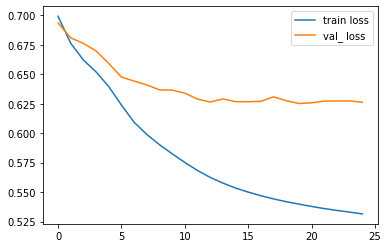

In [20]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val_ loss')
plt.legend()
plt.show()